<a href="https://colab.research.google.com/github/vydra-v-getrax/Chinese_pos_tagging/blob/main/Bi_lstm_for_tagging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import data

In [2]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

import pandas as pd
import numpy as np
from tqdm import tqdm
from tqdm import tqdm
tqdm.pandas()
import json

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Dropout, LSTM, Bidirectional, TimeDistributed, InputLayer
from tensorflow.keras.layers import Embedding, Conv1D, Input, concatenate, SpatialDropout1D, Flatten
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers
import nltk
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from collections import Counter
from keras.utils.vis_utils import plot_model

In [ ]:
# path = '/content/drive/MyDrive/data/' # this is my path to data
# path = 

In [ ]:
df = pd.read_csv(f'{path}parallel_DONE.csv')
df = df.fillna('')
rus = pd.read_csv(f'{path}parallel_rus_22.csv')
rus = rus.fillna('')
df['rus'] = rus.pymorphy
s = pd.read_csv(f'{path}df_char.csv', sep='\t')
df['sent'] = s.sent

In [ ]:
sentences = df.groupby(['sent']).agg({'target':lambda x: list(x),
                                                      'char': lambda x: list(x), 
                                                      'rus': lambda x: list(x)})

In [ ]:
# To run model without test data:
# sent_train, tag_train, rus = sentences['char'], sentences['target'], sentences['rus']

sent_train, sent_test, tag_train, tag_test = train_test_split(sentences['char'], sentences['target'], test_size=0.2, random_state=1)

### Preprocessing

In [ ]:
# Vocabulary

vocab = Counter()
for sent in sent_train:
    sent = [word.lower() for word in sent]
    vocab.update(sent)
filtered_vocab = {word for word in vocab if vocab[word] > 5}
len(filtered_vocab)

746

In [ ]:
# Indexing for words

word2id = {word:i + 2 for i,word in enumerate(filtered_vocab)}
word2id['pad'] = 0
word2id['unk'] = 1  

id2word = {i:word for word, i in word2id.items()}
len(id2word)


748

In [ ]:
# Indexing for POS tags (target)

tag2id = {'pad':0, 'unk':1}  
for tags in tag_train:
    for tag in tags:
      if tag.lower() not in tag2id:
        tag2id[tag.lower()] = len(tag2id)

id2tag = {i:tag for tag, i in tag2id.items()}

In [ ]:
def data2ints(data, smth2id):

    """
    load data to ids
    """

  int_data = []
  for seq in data:
      int_seq = []
      for i in seq:
        int_seq.append(smth2id.get(i.lower(), 1))
  
      int_data.append(int_seq)
  return int_data

In [ ]:
# X_train_ids = data2ints(sent_train, word2id)
# y_train_ids = data2ints(tag_train, tag2id)

X_train_ids, X_test_ids = data2ints(sent_train, word2id), data2ints(sent_test, word2id)
y_train_ids, y_test_ids = data2ints(tag_train, tag2id), data2ints(tag_test, tag2id)
print(X_train_ids[0])
print(y_train_ids[0])


[72, 415, 1, 1, 270, 557, 690, 692, 415, 388, 566, 224, 1, 298, 462, 650, 605, 300, 248, 707, 581, 1, 182, 1, 293, 596, 1, 605, 56, 415, 651, 154, 113, 186, 205]
[2, 3, 4, 4, 5, 6, 4, 7, 7, 8, 8, 9, 2, 9, 10, 10, 11, 12, 12, 9, 13, 2, 2, 2, 2, 4, 4, 11, 9, 9, 2, 2, 8, 8, 11]


In [ ]:
sent_max_len = max(len(x) for x in X_train_ids)
print("максимальная длина предложения:", sent_max_len)

максимальная длина предложения: 338


In [ ]:
# X_train = pad_sequences(X_train_ids, maxlen=sent_max_len, padding='post')
# y_train = pad_sequences(y_train_ids, maxlen=sent_max_len, padding='post')

X_train, X_test = pad_sequences(X_train_ids, maxlen=sent_max_len, padding='post'), pad_sequences(X_test_ids, maxlen=sent_max_len, padding='post')
y_train, y_test = pad_sequences(y_train_ids, maxlen=sent_max_len, padding='post'), pad_sequences(y_test_ids, maxlen=sent_max_len, padding='post')

In [ ]:
# y_train = to_categorical(y_train, num_classes=len(tag2id))
y_train, y_test = to_categorical(y_train, num_classes=len(tag2id)), 
to_categorical(y_test, num_classes=len(tag2id))


In [ ]:
# Indexing for tring of Russian tags

ru2id = {'pad':0, 'unk':1}  
for tags in rus:
    for tag in tags:
      if tag.lower() not in ru2id:
        ru2id[tag.lower()] = len(ru2id)

id2ru = {i:tag for tag, i in ru2id.items()}

In [ ]:
# X_ru_train_ids = data2ints(rus, ru2id)
# X_ru_train = pad_sequences(X_ru_train_ids, maxlen=sent_max_len, padding='post')

X_ru_train_ids, X_ru_test_ids = data2ints(sent_train, ru2id), data2ints(sent_test, ru2id)
X_ru_train, X_ru_test = pad_sequences(X_ru_train_ids, maxlen=sent_max_len, padding='post'), pad_sequences(X_ru_test_ids, maxlen=sent_max_len, padding='post')

## Evaluate on train set

### One input

In [ ]:
word_in = Input(shape=(sent_max_len))
emb_word = Embedding(input_dim=len(word2id), output_dim=20, mask_zero=True)(word_in)
lstm = Bidirectional(LSTM(units=128, return_sequences=True,recurrent_dropout=0.2))(emb_word)
out = TimeDistributed(Dense(len(tag2id), activation="softmax"))(lstm)

model = Model(inputs= word_in, outputs=out)

optimizer = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["acc"])

Model: "model_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_116 (InputLayer)       [(None, 338)]             0         
_________________________________________________________________
embedding_113 (Embedding)    (None, 338, 20)           17160     
_________________________________________________________________
bidirectional_71 (Bidirectio (None, 338, 256)          152576    
_________________________________________________________________
time_distributed_18 (TimeDis (None, 338, 36)           9252      
Total params: 178,988
Trainable params: 178,988
Non-trainable params: 0
_________________________________________________________________


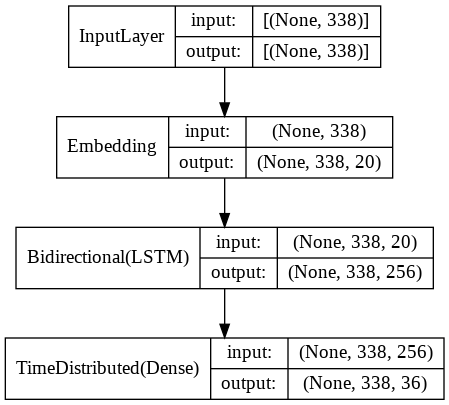

In [ ]:
model.summary()

plot_model(model, show_shapes=True, show_layer_names=False)

In [ ]:
model.fit(X_train, y_train, validation_data=(X_train, y_train), batch_size=32, epochs=10, verbose=1)

Epoch 1/10
29/29 [==============================] - 44s 1s/step - loss: 0.3502 - acc: 0.1813 - val_loss: 0.2755 - val_acc: 0.2017
Epoch 2/10
29/29 [==============================] - 38s 1s/step - loss: 0.2659 - acc: 0.2018 - val_loss: 0.2669 - val_acc: 0.2120
Epoch 3/10
29/29 [==============================] - 39s 1s/step - loss: 0.2716 - acc: 0.2148 - val_loss: 0.2610 - val_acc: 0.2288
Epoch 4/10
29/29 [==============================] - 39s 1s/step - loss: 0.2587 - acc: 0.2570 - val_loss: 0.2476 - val_acc: 0.3454
Epoch 5/10
29/29 [==============================] - 40s 1s/step - loss: 0.2373 - acc: 0.3692 - val_loss: 0.2215 - val_acc: 0.4489
Epoch 6/10
29/29 [==============================] - 40s 1s/step - loss: 0.2073 - acc: 0.4507 - val_loss: 0.1884 - val_acc: 0.5187
Epoch 7/10
29/29 [==============================] - 39s 1s/step - loss: 0.1808 - acc: 0.5330 - val_loss: 0.1602 - val_acc: 0.5863
Epoch 8/10
29/29 [==============================] - 41s 1s/step - loss: 0.1515 - acc: 0.60

### Two inputs

In [ ]:
# First input: characters

word_in = Input(shape=(sent_max_len))
emb_word = Embedding(input_dim=len(word2id), output_dim=12)(word_in)
lstm = Bidirectional(LSTM(units=128, recurrent_dropout=0.3, return_sequences=True))(emb_word)

# Second input: Russian tags
char_in = Input(shape=(sent_max_len))
emb_char = Embedding(input_dim=len(ru2id), output_dim=12, input_length=sent_max_len)(char_in)
char_enc = Conv1D(filters=12, kernel_size=1)(emb_char)
char_lstm = Bidirectional(LSTM(units=128, recurrent_dropout=0.2, return_sequences=True))(char_enc)

# Concatenation of BiLSTMs
x = concatenate([lstm, char_lstm])
main_lstm = Bidirectional(LSTM(units=128,
                               recurrent_dropout=0.2, return_sequences=True))(x)
out = TimeDistributed(Dense(len(tag2id), activation="softmax"))(main_lstm)

model = Model(inputs=[char_in, word_in], outputs=out)

optimizer = optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=['acc'])

NameError: ignored

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=False)
model.summary()

Model: "model_27"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_119 (InputLayer)          [(None, 338)]        0                                            
__________________________________________________________________________________________________
input_120 (InputLayer)          [(None, 338)]        0                                            
__________________________________________________________________________________________________
embedding_116 (Embedding)       (None, 338, 12)      10296       input_119[0][0]                  
__________________________________________________________________________________________________
embedding_117 (Embedding)       (None, 338, 12)      264         input_120[0][0]                  
___________________________________________________________________________________________

In [ ]:
model.fit([X_ru_train, X_train], y_train, validation_data=([X_ru_train, X_train], y_train), batch_size=16, epochs=10, verbose=1)

Epoch 1/10
57/57 [==============================] - 267s 4s/step - loss: 1.3886 - acc: 0.8251 - val_loss: 0.2962 - val_acc: 0.9153
Epoch 2/10
57/57 [==============================] - 247s 4s/step - loss: 0.2945 - acc: 0.9121 - val_loss: 0.2697 - val_acc: 0.9151
Epoch 3/10
57/57 [==============================] - 252s 4s/step - loss: 0.2732 - acc: 0.9143 - val_loss: 0.2642 - val_acc: 0.9191
Epoch 4/10
57/57 [==============================] - 250s 4s/step - loss: 0.2633 - acc: 0.9188 - val_loss: 0.2605 - val_acc: 0.9195
Epoch 5/10
57/57 [==============================] - 251s 4s/step - loss: 0.2623 - acc: 0.9184 - val_loss: 0.2581 - val_acc: 0.9200
Epoch 6/10
57/57 [==============================] - 253s 4s/step - loss: 0.2668 - acc: 0.9176 - val_loss: 0.2514 - val_acc: 0.9234
Epoch 7/10
57/57 [==============================] - 253s 4s/step - loss: 0.2620 - acc: 0.9208 - val_loss: 0.2430 - val_acc: 0.9257
Epoch 8/10
57/57 [==============================] - 250s 4s/step - loss: 0.2352 - a

After 10 epochs validation accuracy for 2-way model is better

## Evaluate on test


### One input

In [ ]:
# Fine architecture: Conv1D + Bilstm + Bilstm + TimeDistributed

word_in = Input(shape=(sent_max_len))
emb_word = Embedding(input_dim=len(word2id), output_dim=20, mask_zero=True)(word_in)
emb_enc = Conv1D(filters=12, kernel_size=1)(emb_word)

lstm = Bidirectional(LSTM(units=128, return_sequences=True,recurrent_dropout=0.2))(emb_enc)
lstm2 = Bidirectional(LSTM(units=128, return_sequences=True,recurrent_dropout=0.2))(lstm)
out = TimeDistributed(Dense(len(tag2id), activation="softmax"))(lstm2)

model = Model(inputs= word_in, outputs=out)

optimizer = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["acc"])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 338)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 338, 20)           14960     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 338, 12)           252       
_________________________________________________________________
bidirectional_2 (Bidirection (None, 338, 256)          144384    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 338, 256)          394240    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 338, 35)           8995      
Total params: 562,831
Trainable params: 562,831
Non-trainable params: 0
_____________________________________________________

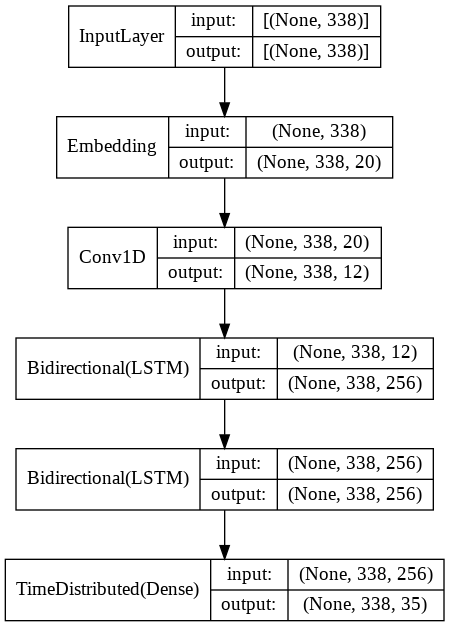

In [ ]:
model.summary()

plot_model(model, show_shapes=True, show_layer_names=False)

In [ ]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=16, epochs=30, verbose=1) 

Epoch 1/30
46/46 [==============================] - 197s 3s/step - loss: 1.6156 - acc: 0.8866 - val_loss: 0.3071 - val_acc: 0.9082
Epoch 2/30
46/46 [==============================] - 157s 3s/step - loss: 0.2941 - acc: 0.9117 - val_loss: 0.2578 - val_acc: 0.9200
Epoch 3/30
46/46 [==============================] - 160s 3s/step - loss: 0.2776 - acc: 0.9140 - val_loss: 0.2525 - val_acc: 0.9212
Epoch 4/30
46/46 [==============================] - 159s 3s/step - loss: 0.2838 - acc: 0.9118 - val_loss: 0.2497 - val_acc: 0.9219
Epoch 5/30
46/46 [==============================] - 158s 3s/step - loss: 0.2741 - acc: 0.9151 - val_loss: 0.2471 - val_acc: 0.9241
Epoch 6/30
46/46 [==============================] - 159s 3s/step - loss: 0.2670 - acc: 0.9185 - val_loss: 0.2444 - val_acc: 0.9262
Epoch 7/30
46/46 [==============================] - 158s 3s/step - loss: 0.2528 - acc: 0.9226 - val_loss: 0.2397 - val_acc: 0.9270
Epoch 8/30
46/46 [==============================] - 156s 3s/step - loss: 0.2535 - a

In [ ]:
model_one = model

In [ ]:
# training  for 10 more epochs

model_one.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=16, epochs=30, verbose=1)

Epoch 1/30
46/46 [==============================] - 159s 3s/step - loss: 0.0810 - acc: 0.9756 - val_loss: 0.0890 - val_acc: 0.9738
Epoch 2/30
46/46 [==============================] - 158s 3s/step - loss: 0.0788 - acc: 0.9763 - val_loss: 0.0870 - val_acc: 0.9748
Epoch 3/30
46/46 [==============================] - 157s 3s/step - loss: 0.0779 - acc: 0.9765 - val_loss: 0.0864 - val_acc: 0.9750
Epoch 4/30
46/46 [==============================] - 157s 3s/step - loss: 0.0760 - acc: 0.9768 - val_loss: 0.0861 - val_acc: 0.9748
Epoch 5/30
46/46 [==============================] - 157s 3s/step - loss: 0.0750 - acc: 0.9770 - val_loss: 0.0851 - val_acc: 0.9753
Epoch 6/30
46/46 [==============================] - 157s 3s/step - loss: 0.0736 - acc: 0.9774 - val_loss: 0.0841 - val_acc: 0.9754
Epoch 7/30
46/46 [==============================] - 156s 3s/step - loss: 0.0717 - acc: 0.9780 - val_loss: 0.0833 - val_acc: 0.9755
Epoch 8/30
46/46 [==============================] - 156s 3s/step - loss: 0.0708 - a

KeyboardInterrupt: ignored

### Two inputs


In [ ]:
# Input characters
word_in = Input(shape=(sent_max_len))
emb_word = Embedding(input_dim=len(word2id), output_dim=12)(word_in)
lstm = Bidirectional(LSTM(units=128, recurrent_dropout=0.3, return_sequences=True))(emb_word)

# Input russian tags
char_in = Input(shape=(sent_max_len))
emb_char = Embedding(input_dim=len(ru2id), output_dim=12, input_length=sent_max_len)(char_in)
char_enc = Conv1D(filters=12, kernel_size=1)(emb_char)
char_lstm = Bidirectional(LSTM(units=128, recurrent_dropout=0.2, return_sequences=True))(char_enc)

# Concatenation and final BiLSTM
x = concatenate([lstm, char_lstm])
main_lstm = Bidirectional(LSTM(units=128,
                               recurrent_dropout=0.2, return_sequences=True))(x)
out = TimeDistributed(Dense(len(tag2id)
model = Model(inputs=[char_in, word_in], outputs=out)

optimizer = optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=['acc'])

(None, 338, 12)
(None, 338, 12)
(None, 338, 256)
(None, 338, 35)
shape (None, 338) (None, 338)


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 338)]        0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 338)]        0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 338, 12)      324         input_6[0][0]                    
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 338, 12)      8976        input_5[0][0]                    
____________________________________________________________________________________________

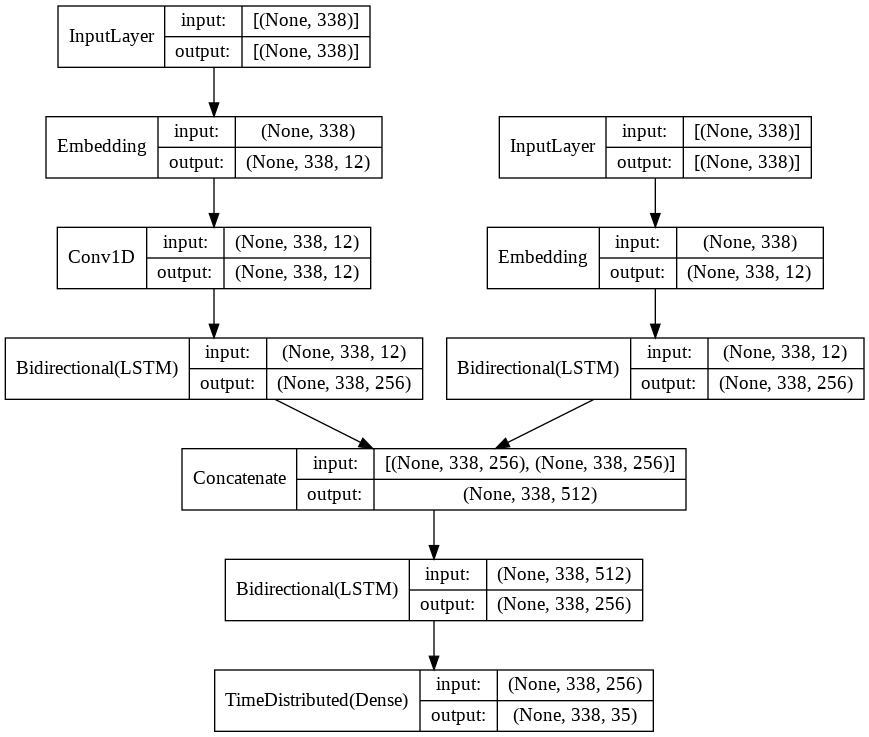

In [ ]:
model.summary()

plot_model(model, show_shapes=True, show_layer_names=False)

In [ ]:
model.fit([X_ru_train, X_train], y_train, validation_data=([X_ru_train, X_train], y_train), batch_size=16, epochs=30, verbose=1)

Epoch 1/30
46/46 [==============================] - 297s 6s/step - loss: 1.4678 - acc: 0.8099 - val_loss: 0.3148 - val_acc: 0.9120
Epoch 2/30
46/46 [==============================] - 258s 6s/step - loss: 0.2994 - acc: 0.9122 - val_loss: 0.2769 - val_acc: 0.9132
Epoch 3/30
46/46 [==============================] - 256s 6s/step - loss: 0.2768 - acc: 0.9139 - val_loss: 0.2700 - val_acc: 0.9128
Epoch 4/30
46/46 [==============================] - 255s 6s/step - loss: 0.2666 - acc: 0.9171 - val_loss: 0.2664 - val_acc: 0.9180
Epoch 5/30
46/46 [==============================] - 255s 6s/step - loss: 0.2594 - acc: 0.9197 - val_loss: 0.2644 - val_acc: 0.9186
Epoch 6/30
46/46 [==============================] - 254s 6s/step - loss: 0.2627 - acc: 0.9189 - val_loss: 0.2626 - val_acc: 0.9190
Epoch 7/30
46/46 [==============================] - 251s 5s/step - loss: 0.2603 - acc: 0.9193 - val_loss: 0.2632 - val_acc: 0.9175
Epoch 8/30
46/46 [==============================] - 252s 6s/step - loss: 0.2487 - a

In [ ]:
model.save(f'{path}model2lstm')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/data/model2lstm/assets


In [ ]:
# Train more for 10 more epochs

model.fit([X_ru_train, X_train], y_train, validation_9data=([X_ru_train, X_train], y_train), batch_size=16, epochs=10, verbose=1)

Epoch 1/10
46/46 [==============================] - 256s 6s/step - loss: 0.0838 - acc: 0.9747 - val_loss: 0.0775 - val_acc: 0.9767
Epoch 2/10
46/46 [==============================] - 256s 6s/step - loss: 0.0794 - acc: 0.9758 - val_loss: 0.0745 - val_acc: 0.9774
Epoch 3/10
46/46 [==============================] - 256s 6s/step - loss: 0.0764 - acc: 0.9767 - val_loss: 0.0705 - val_acc: 0.9788
Epoch 4/10
46/46 [==============================] - 256s 6s/step - loss: 0.0732 - acc: 0.9778 - val_loss: 0.0680 - val_acc: 0.9796
Epoch 5/10
46/46 [==============================] - 255s 6s/step - loss: 0.0705 - acc: 0.9785 - val_loss: 0.0657 - val_acc: 0.9797
Epoch 6/10
46/46 [==============================] - 257s 6s/step - loss: 0.0679 - acc: 0.9789 - val_loss: 0.0621 - val_acc: 0.9805
Epoch 7/10
46/46 [==============================] - 254s 6s/step - loss: 0.0659 - acc: 0.9793 - val_loss: 0.0608 - val_acc: 0.9813
Epoch 8/10
46/46 [==============================] - 254s 6s/step - loss: 0.0633 - a